<a href="https://colab.research.google.com/github/sangse/Stock_AI_transformer/blob/main/Transformer_EncoderBlock_NewStockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Transformer Classification Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os

## Data Loading

In [ ]:
X = torch.load('/content/drive/MyDrive/data/tmp_x_tensor.pt')
y = torch.load('/content/drive/MyDrive/data/tmp_y_tensor.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
y_label = y[:,0,-1].type(torch.LongTensor)
y_label.to(device)
X.to(device)
y.to(device)
print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")

X shape : torch.Size([3153, 24, 8])
y shape : torch.Size([3153, 12, 8])


## Model Define

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=24):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)]

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, num_classes):
        super(TimeSeriesTransformer, self).__init__()
        self.linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.linear(x)  # Project input data to d_model dimensions
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x[:,:,0]
        output = self.decoder(x)
        return output


## Param Setting & Dataset

In [ ]:
# Hyperparameters
input_dim = 8  # Number of features
seq_length = 24  # Sequence length
d_model = 128  # Dimension of the model
nhead = 4  # Number of attention heads
num_layers = 2  # Number of Transformer layers
num_classes = 10  # Number of output classes

# Initialize the model
model = TimeSeriesTransformer(input_dim, d_model, nhead, num_layers, num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train,y_train = X[:int(0.8*len(X))],y_label[:int(0.8*len(y))]
X_val,y_val = X[int(0.8*len(X)):],y_label[int(0.8*len(y)):]


# Data Loader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## Model Learning

In [ ]:
num_epochs = 100  # 학습 에폭 수
num_samples = len(train_loader.dataset)  # 전체 훈련 데이터 수
num_val_samples = len(val_loader.dataset)  # 전체 검증 데이터 수

best_val_loss = float('inf')  # 가장 좋은 검증 손실을 저장하기 위한 변수 초기화

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0

    # 훈련 루프
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # 그래디언트 초기화
        outputs = model(inputs)  # 모델을 통한 순전파
        loss = criterion(outputs, targets)  # 손실 계산
        loss.backward()  # 역전파 실행
        optimizer.step()  # 매개변수 업데이트

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / num_samples

    # 검증 루프
    model.eval()  # 모델을 평가 모드로 설정
    running_val_loss = 0.0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)

    val_loss = running_val_loss / num_val_samples
    print(f'Epoch {epoch+1}  - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

    # 검증 손실이 현재까지의 최소값보다 낮을 경우, 모델 상태 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model.pth')
        print(f'New best model saved at epoch {epoch+1} with validation loss {val_loss:.4f}')


# Transformer Stock Prediction

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import math
import torch.nn.functional as F
import copy
from sklearn.model_selection import train_test_split

def mae_loss(output, target):
    return F.l1_loss(output, target)

## Data Loading

In [3]:
X = torch.load('/content/drive/MyDrive/data/tmp_x_v2.pt')
y = torch.load('/content/drive/MyDrive/data/tmp_y_v2.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = X.to(device).to(dtype = torch.float32)
y = y.to(device).to(dtype = torch.float32)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([134290, 12, 11])
y shape: torch.Size([134290, 12, 11])


In [ ]:
X = torch.load('/content/drive/MyDrive/data/tmp_x_v3.pt')
y = torch.load('/content/drive/MyDrive/data/tmp_y_v3.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = X.to(device).to(dtype = torch.float32)
y = y.to(device).to(dtype = torch.float32)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([986707, 12, 11])
y shape: torch.Size([986707, 12, 10])


## Model Define

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=24):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model).to(device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1),:]

class TimeSeriesTransformerPrediction(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, future_seq):
        super(TimeSeriesTransformerPrediction, self).__init__()
        self.linear = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout= 0.1)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_layers)
        self.linear_dim2 = nn.Linear(12, future_seq)
        self.linear_output = nn.Linear(d_model, 1)


    def forward(self, x, y, mode):
        eval_x = copy.deepcopy(x)

        x = self.linear(x)

        x = self.pos_encoder(x)

        x = x.permute(1, 0, 2)

        x = self.transformer_encoder(x) # seq/batch/d_model
        x = x.permute(1, 2, 0) # batch/d_model/seq

        x = self.linear_dim2(x)

        x = x.permute(0, 2, 1) # batch/seq/d_model

        output = self.linear_output(x)

        return output


## Parameter Setting & Dataset

In [21]:
# Hyperparameters
input_dim = 11  # Number of features
seq_length = 12  # Sequence length
d_model = 128  # Dimension of the model
nhead = 4  # Number of attention heads 4
num_layers = 2  # Number of Transformer layers 2
future_seq = 4  # Number of output classes


# Initialize the model
model = TimeSeriesTransformerPrediction(input_dim, d_model, nhead, num_layers, future_seq).to(device)
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train,X_val,y_train,y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Loader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

## Model Learning

In [ ]:
num_epochs = 500  # 학습 에폭 수
num_samples = len(train_loader.dataset)  # 전체 훈련 데이터 수
num_val_samples = len(val_loader.dataset)  # 전체 검증 데이터 수

best_val_loss = float('inf')  # 가장 좋은 검증 손실을 저장하기 위한 변수 초기화

for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0

    # 훈련 루프
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # 그래디언트 초기화
        outputs = model(inputs,targets,mode='eval')  # 모델을 통한 순전파
        loss = criterion(outputs.squeeze(), targets[:,:4,0])  # 손실 계산
        loss.backward()  # 역전파 실행
        optimizer.step()  # 매개변수 업데이트

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / num_samples

    # 검증 루프
    model.eval()  # 모델을 평가 모드로 설정
    running_val_loss = 0.0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, targets in val_loader:
            outputs = model(inputs,targets,mode='eval')
            loss = criterion(outputs.squeeze(), targets[:,:4,0])
            running_val_loss += loss.item() * inputs.size(0)

    val_loss = running_val_loss / num_val_samples
    print(f'Epoch {epoch+1}  - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}')

    # 검증 손실이 현재까지의 최소값보다 낮을 경우, 모델 상태 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'/content/drive/MyDrive/best_model_classfication_feature_v2.pth')
        print(f'New best model saved at epoch {epoch+1} with validation loss {val_loss:.4f}')

Epoch 1  - Training Loss: 0.0847 - Validation Loss: 0.0347
New best model saved at epoch 1 with validation loss 0.0347
Epoch 2  - Training Loss: 0.0326 - Validation Loss: 0.0335
New best model saved at epoch 2 with validation loss 0.0335
Epoch 3  - Training Loss: 0.0382 - Validation Loss: 0.0463
Epoch 4  - Training Loss: 0.0341 - Validation Loss: 0.0236
New best model saved at epoch 4 with validation loss 0.0236
Epoch 5  - Training Loss: 0.0298 - Validation Loss: 0.0254
Epoch 6  - Training Loss: 0.0375 - Validation Loss: 0.0288
Epoch 7  - Training Loss: 0.0316 - Validation Loss: 0.0366
Epoch 8  - Training Loss: 0.0292 - Validation Loss: 0.0421
Epoch 9  - Training Loss: 0.0290 - Validation Loss: 0.0392
Epoch 10  - Training Loss: 0.0272 - Validation Loss: 0.0404
Epoch 11  - Training Loss: 0.0267 - Validation Loss: 0.0517
Epoch 12  - Training Loss: 0.0259 - Validation Loss: 0.0539
Epoch 13  - Training Loss: 0.0244 - Validation Loss: 0.0422
Epoch 14  - Training Loss: 0.0251 - Validation Lo

## Model Prediction Samples

torch.Size([64, 12, 1])
torch.Size([64, 12, 11])


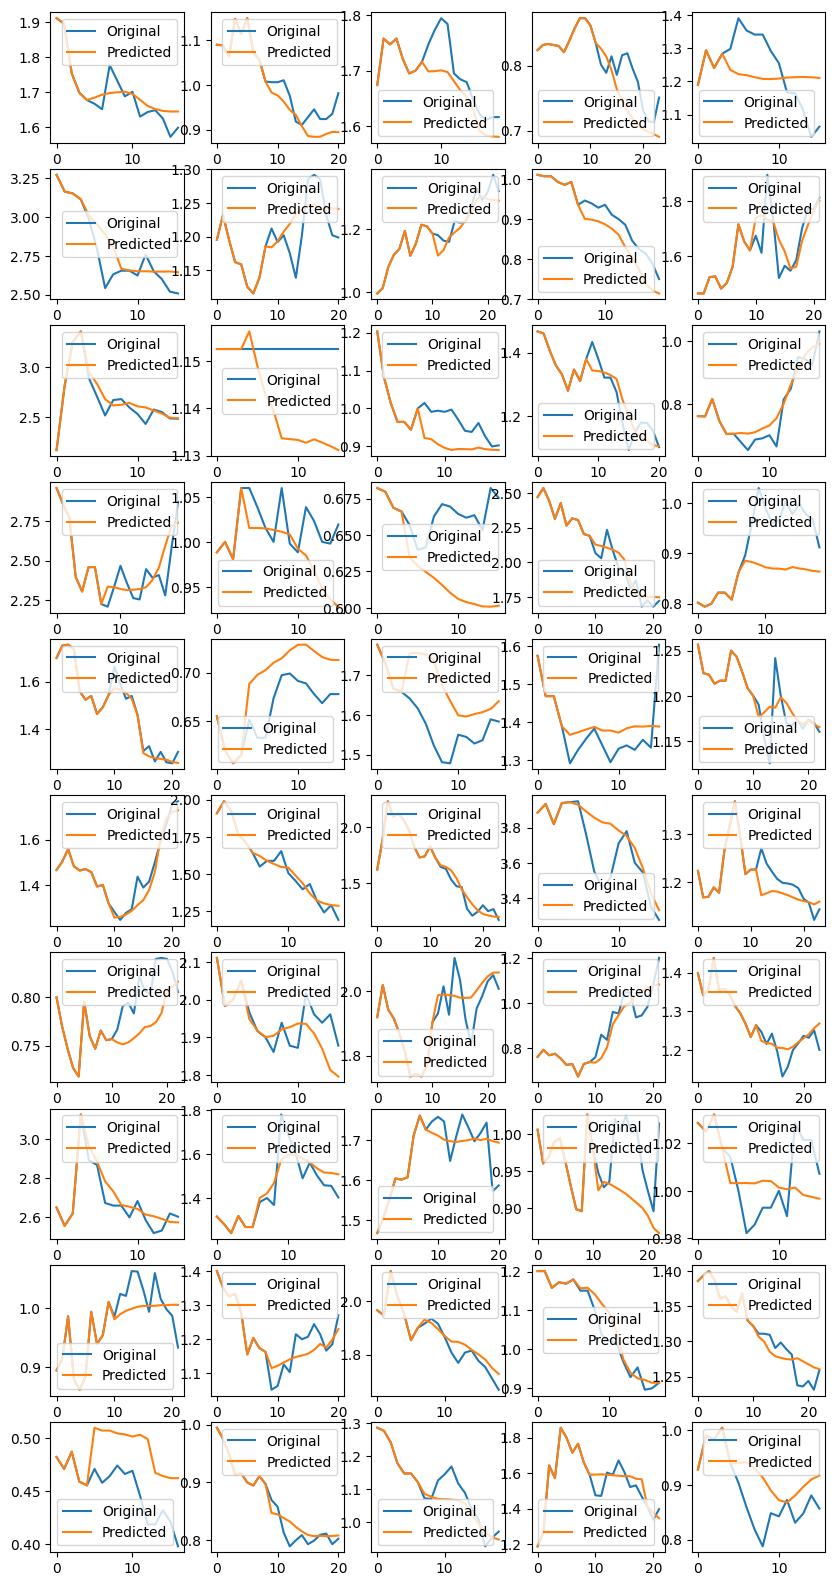

torch.Size([64, 12, 1])
torch.Size([64, 12, 11])


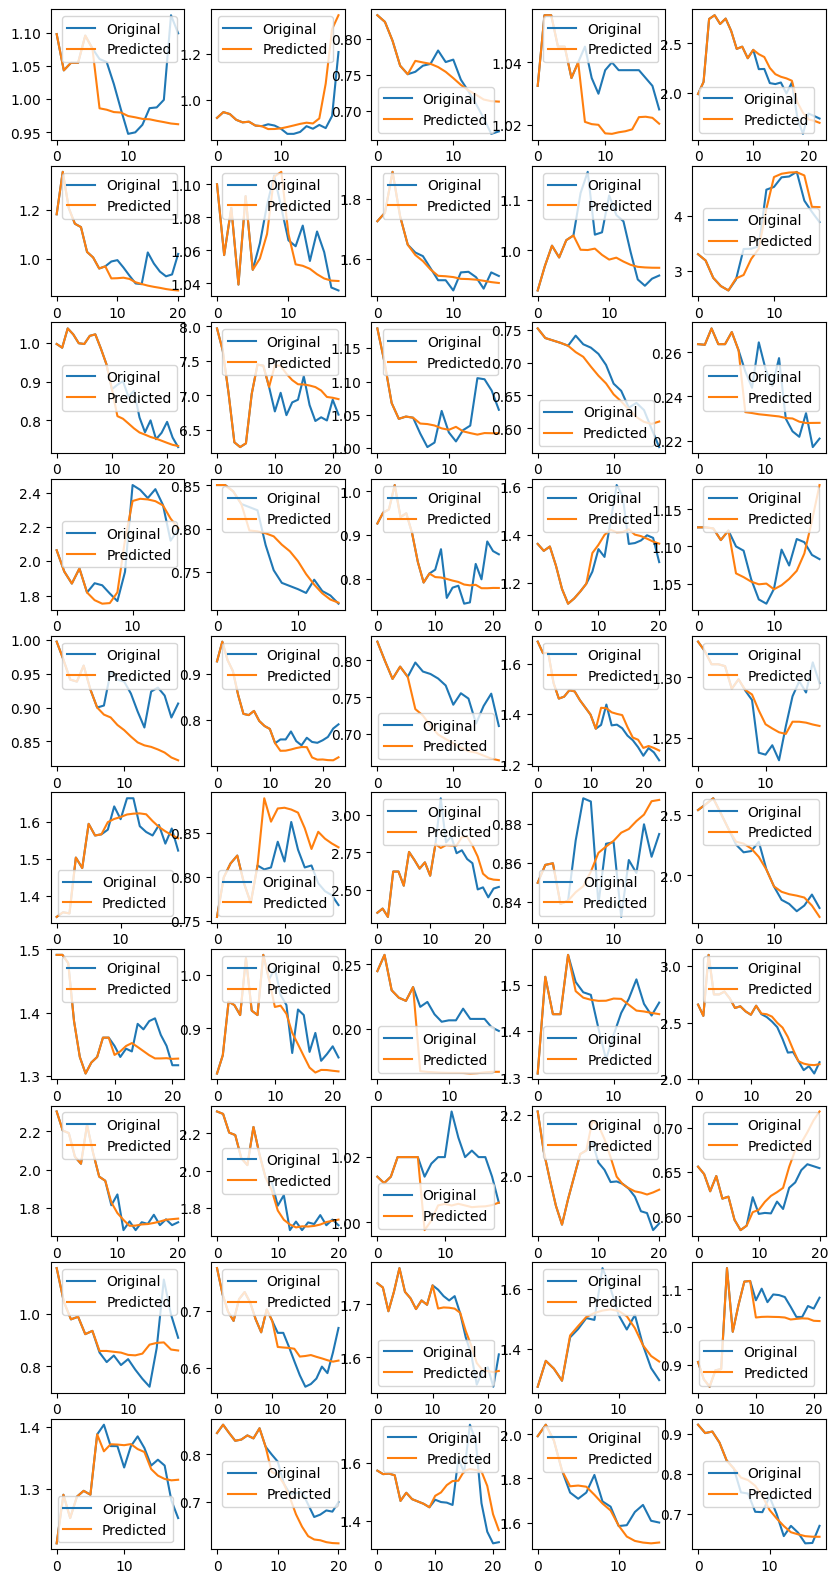

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_classfication_feature_v2.pth',map_location=torch.device('cpu')))
model.eval()
count = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        outputs = model(inputs,targets,'eval')
        print(outputs.shape)
        print(targets.shape)
        fig, axes = plt.subplots(nrows=10, ncols=5 ,figsize=(10, 20))
        for k in range(10):
          for z in range(5):

            ori = torch.cat([inputs[k*5+z,:,0].cpu(),targets[k*5+z,:,0].cpu()])
            ori = ori[ori != 0]
            pred = torch.cat([inputs[k*5+z,:,0].cpu(),outputs[k*5+z,:,0].cpu()])
            pred = pred[pred != 0]


            sns.lineplot(ori, label='Original',ax = axes[k][z])
            sns.lineplot(pred, label='Predicted',ax = axes[k][z])
        count += 1
        if count == 2:
            break
        plt.show()

torch.Size([81, 12, 11])
torch.Size([81, 12, 11])


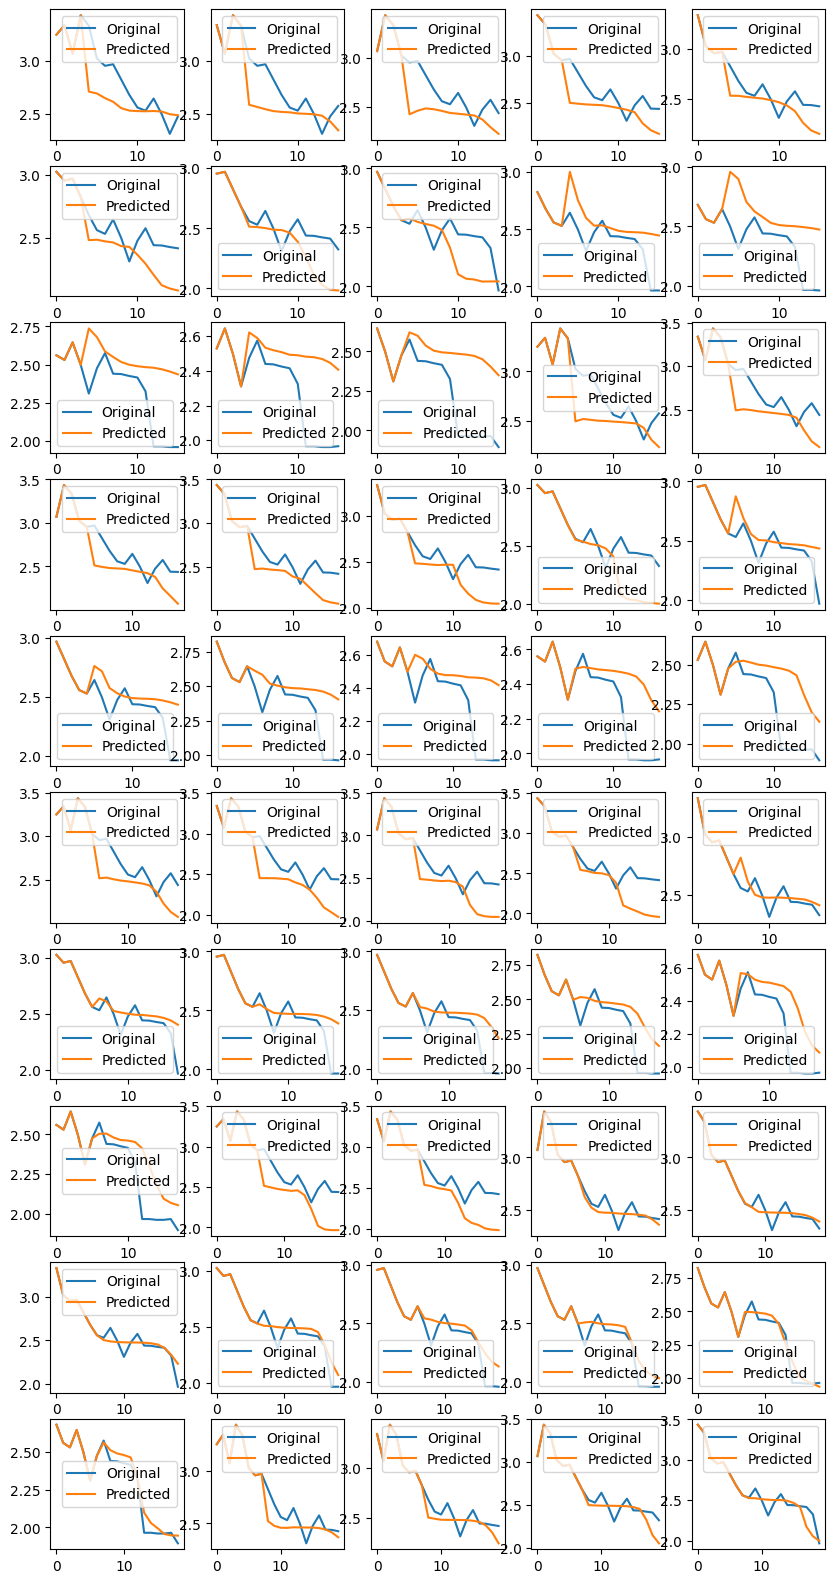

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('/content/drive/MyDrive/best_model_classfication_feature.pth',map_location=torch.device('cpu')))
model.eval()

selected_data = X[133299:133380,:,:]
selected_target_data = y[133299:133380,:,:]
print(selected_data.shape)
print(selected_target_data.shape)

with torch.no_grad():
    outputs = model(selected_data[-64:],selected_target_data[-64:],'eval')
    fig, axes = plt.subplots(nrows=10, ncols=5 ,figsize=(10, 20))

    for k in range(10):
      for z in range(5):

        ori = torch.cat([selected_data[k*5+z,:,0].cpu(),selected_target_data[k*5+z,:,0].cpu()])
        ori = ori[ori != 0]
        pred = torch.cat([selected_data[k*5+z,:,0].cpu(),outputs[k*5+z,:,0].cpu()])
        pred = pred[pred != 0]

        sns.lineplot(ori, label='Original',ax = axes[k][z])
        sns.lineplot(pred, label='Predicted',ax = axes[k][z])